### CNN-LSTM_v5

- 파이썬 버전: 3.8.18
- hyperparameter tunning용
    - learning rate
    - cnn hyperparameter
    - seq_len: 160으로 설정 + cnn 최적 파라미터 = 성능 최대화 도출하는 코드

### 1. Library 불러오기, SEED 설정, CUDA 사용

In [1]:
# 필요 라이브러리 import

# Pytorch
import torch
import torch.optim as optim
import torch.nn as nn

# Dataset 관련
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import sequence as sq # 사용자 정의 함수 불러오기

# 성능 평가 관련
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix
from collections import Counter

# Visualization 관련
import matplotlib.pyplot as plt
import seaborn as sns

# 하이퍼파라미터 튜닝
import optuna
from optuna.pruners import MedianPruner
from sklearn.model_selection import TimeSeriesSplit

# 운영체제 관련
import platform

'''
딥러닝 학습을 진행할 때, 가중치를 임의의 값으로 초기화하여 학습을 수행하는 데, 
실험을 동일하게 진행하기 위해서는 난수를 동일하게 생성해야 한다.
Pytorch에서 random seed를 고정하기 위해 manual_seed를 사용한다.
'''

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# 운영체제별 device 설정
os_name = platform.system()
if os_name == 'Windows':
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"이 PC는 윈도우 운영 체제입니다. {device} is available")
elif os_name == 'Darwin':
    device = torch.device("mps" if torch.backends.mps.is_available else "cpu")
    print(f"이 PC는 맥(OS X) 운영 체제입니다. {device} is available")
else:
    print(f"이 PC는 다른 운영 체제입니다: {os_name}")


이 PC는 윈도우 운영 체제입니다. cuda:0 is available


### 2. 데이터 불러오기 및 전처리 (Binary, Scale, Tensor, train&valid&test split)

In [3]:
# 데이터 불러오기
file_path = '../../data/' # 경로 설정
df = pd.read_csv(file_path + 'bitcoin_data_num_rows_gt_5.csv')
#df = df.iloc[:10000]
df['returns_next10m'] = df['returns_next10m'].apply(lambda x: 0 if x <= 0 else 1) # 종속변수 이진분류화
df = df.sort_values(by='window_start', ascending=True) # 시간순 정렬

# sequence length를 기준으로 sequence 데이터 생성
seq_len = 160 # 20, 40, 80, 160, 320
X, y = sq.create_sequence(df, seq_len=seq_len) # 사용자 정의 함수
# Tensor화
X = torch.FloatTensor(X).to(device)
y = torch.FloatTensor(y).to(device)
print('Full Data Size:', X.size(), y.size())

# split (60% / 20% / 20%)
train_split = int((X.size(0)) * 0.6)
valid_split = int((X.size(0)) * 0.8)

X_train_seq = X[:train_split]
X_val_seq = X[train_split:valid_split]
X_test_seq = X[valid_split:]
y_train_seq = y[:train_split]
y_val_seq = y[train_split:valid_split]
y_test_seq = y[valid_split:]

print('Train Size:', X_train_seq.size(), y_train_seq.size())
print('Valid Size:', X_val_seq.size(), y_val_seq.size())
print('Test Size:', X_test_seq.size(), y_test_seq.size())


Full Data Size: torch.Size([76616, 160, 77]) torch.Size([76616, 1])
Train Size: torch.Size([45969, 160, 77]) torch.Size([45969, 1])
Valid Size: torch.Size([15323, 160, 77]) torch.Size([15323, 1])
Test Size: torch.Size([15324, 160, 77]) torch.Size([15324, 1])


In [4]:
# Dataset과 DataLoader를 이용해 배치 데이터로 만든다.
train = torch.utils.data.TensorDataset(X_train_seq, y_train_seq)
valid = torch.utils.data.TensorDataset(X_val_seq, y_val_seq)
test = torch.utils.data.TensorDataset(X_test_seq, y_test_seq)
batch_size = 128 # 32, 64, 128
train_loader =  torch.utils.data.DataLoader(dataset=train, batch_size=batch_size, shuffle=False, drop_last=True) # 시계열 데이터기에 shuffle X, 마지막 batch 버림
valid_loader = torch.utils.data.DataLoader(dataset=valid, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size=batch_size, shuffle=False)


### 3. 모델 정의

In [5]:
# CNN-LSTM 모델 정의
class CNNLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, cnn_out_channels1, cnn_out_channels2, kernel_size, stride, padding):
        super(CNNLSTMModel, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=input_size, out_channels=cnn_out_channels1, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Conv1d(in_channels=cnn_out_channels1, out_channels=cnn_out_channels2, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )
        self.lstm = nn.LSTM(input_size=cnn_out_channels2, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        x = x.permute(0, 2, 1)
        out = self.cnn(x)
        out = out.permute(0, 2, 1)
        out, _ = self.lstm(out)
        out = self.fc(out[:, -1, :]) 
        return out

In [6]:
import optuna
from optuna.exceptions import TrialPruned

def objective(trial):
    # CNN 파라미터 설정을 위한 탐색 공간 정의
    cnn_out_channels1 = trial.suggest_int('cnn_out_channels1', 32, 128)
    cnn_out_channels2 = trial.suggest_int('cnn_out_channels2', 64, 256)
    kernel_size = trial.suggest_int('kernel_size', 2, 4)
    stride = trial.suggest_int('stride', 1, 2)
    padding = trial.suggest_int('padding', 0, 2)

    try:
        # 모델 초기화
        model = CNNLSTMModel(input_size=77, hidden_size=128, num_layers=2, num_classes=1, 
                             cnn_out_channels1=cnn_out_channels1, cnn_out_channels2=cnn_out_channels2, 
                             kernel_size=kernel_size, stride=stride, padding=padding)
        model.to(device)

        # 손실 함수와 옵티마이저 설정
        criterion = nn.BCEWithLogitsLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.0001)

        # 모델 학습
        model.train()
        for epoch in range(20):  # 여러 에포크로 학습을 진행할 수 있음
            epoch_loss = 0.0
            for batch_idx, (data, target) in enumerate(train_loader):
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
            epoch_loss /= len(train_loader)

        # 검증 손실 계산
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for data, target in valid_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)
                val_loss += loss.item()
        val_loss /= len(valid_loader)

        return val_loss
    except RuntimeError as e:
        # 여기서 특정 오류 메시지를 확인하고, 해당하는 경우 TrialPruned 예외를 발생시키도록 조건을 추가할 수 있음
        print(f"오류 발생, 시도 제외: {e}")
        raise TrialPruned()  # 현재 시도를 조기 중단하고 다음 시도로 넘어감

# Optuna 스터디 생성 및 최적화 실행
study = optuna.create_study(direction='minimize', pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=30)

print("최적의 파라미터: ", study.best_params)


[I 2024-03-23 12:34:54,196] A new study created in memory with name: no-name-62815390-60b8-40be-8740-6af6b1b7df41
[I 2024-03-23 12:36:10,986] Trial 0 finished with value: 0.6522488584121068 and parameters: {'cnn_out_channels1': 98, 'cnn_out_channels2': 238, 'kernel_size': 4, 'stride': 1, 'padding': 0}. Best is trial 0 with value: 0.6522488584121068.
[I 2024-03-23 12:37:19,981] Trial 1 finished with value: 0.49833454514543213 and parameters: {'cnn_out_channels1': 90, 'cnn_out_channels2': 230, 'kernel_size': 3, 'stride': 1, 'padding': 2}. Best is trial 1 with value: 0.49833454514543213.
[I 2024-03-23 12:37:55,032] Trial 2 finished with value: 0.6710218340158463 and parameters: {'cnn_out_channels1': 88, 'cnn_out_channels2': 71, 'kernel_size': 4, 'stride': 2, 'padding': 0}. Best is trial 1 with value: 0.49833454514543213.
[I 2024-03-23 12:38:47,320] Trial 3 finished with value: 0.5071091139068206 and parameters: {'cnn_out_channels1': 41, 'cnn_out_channels2': 153, 'kernel_size': 4, 'stride'

KeyboardInterrupt: 

In [7]:
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 최적의 파라미터 로드 (Optuna 스터디 결과로부터 얻은 최적의 파라미터를 사용)
#best_params = study.best_params
best_params = {'cnn_out_channels1': 39, 'cnn_out_channels2': 192, 'kernel_size': 2, 'stride': 1, 'padding': 2}


# 모델 정의
model = CNNLSTMModel(input_size=77, hidden_size=1024, num_layers=4, num_classes=1, 
                     cnn_out_channels1=best_params['cnn_out_channels1'], 
                     cnn_out_channels2=best_params['cnn_out_channels2'],
                     kernel_size=best_params['kernel_size'], 
                     stride=best_params['stride'], 
                     padding=best_params['padding']).to(device)

# 손실 함수와 옵티마이저
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# 데이터 로더 생성
batch_size = 128
train_loader = DataLoader(dataset=train, batch_size=batch_size, shuffle=False, drop_last=True)
valid_loader = DataLoader(dataset=valid, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test, batch_size=batch_size, shuffle=False)

# 모델 학습
def train_model(model, train_loader, valid_loader, criterion, optimizer, epochs=12):
    for epoch in range(epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
        
        # 검증 데이터에 대한 성능 평가
        model.eval()
        with torch.no_grad():
            valid_loss = 0
            for X_batch, y_batch in valid_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                valid_loss += loss.item()
        print(f'Epoch {epoch+1}, Validation Loss: {valid_loss / len(valid_loader)}')

# 모델 학습 실행
train_model(model, train_loader, valid_loader, criterion, optimizer)

# 테스트 데이터에 대한 성능 평가
def evaluate_model(model, test_loader):
    model.eval()
    with torch.no_grad():
        test_loss = 0
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            test_loss += loss.item()
    print(f'Test Loss: {test_loss / len(test_loader)}')

# 테스트 데이터 평가 실행
evaluate_model(model, test_loader)


Epoch 1, Validation Loss: 0.6815043186148008
Epoch 2, Validation Loss: 0.5302377589046955
Epoch 3, Validation Loss: 0.5215344813962778
Epoch 4, Validation Loss: 0.5137392056485017
Epoch 5, Validation Loss: 0.5066415763149659
Epoch 6, Validation Loss: 0.5035329976429542
Epoch 7, Validation Loss: 0.5007433543602625
Epoch 8, Validation Loss: 0.49882341250777246
Epoch 9, Validation Loss: 0.49683051854372023
Epoch 10, Validation Loss: 0.496154190475742
Epoch 11, Validation Loss: 0.496876913929979
Epoch 12, Validation Loss: 0.4978896447767814
Test Loss: 0.470512601484855


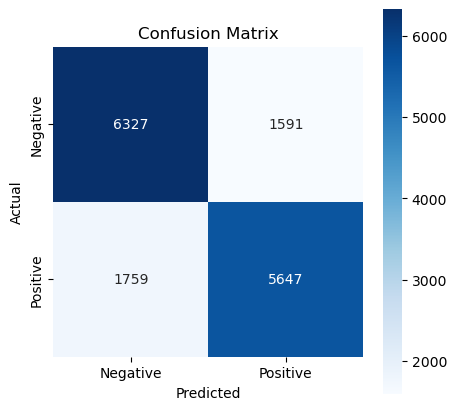

Accuracy: 0.7814
Precision: 0.7802
Recall: 0.7625
F1 Score: 0.7712


In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# 모델을 평가하고 성능 지표를 출력하는 함수
def evaluate_model_performance(model, test_loader):
    model.eval()
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            # 예측 결과를 CPU로 이동시키고, 클래스를 결정하기 위해 임계값 0.5 적용
            predictions = (torch.sigmoid(outputs) > 0.5).int().cpu().numpy()
            all_predictions.extend(predictions.flatten())
            all_targets.extend(y_batch.cpu().numpy())

def plot_confusion_matrix(model, test_loader):
    model.eval()
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            predictions = (torch.sigmoid(outputs) > 0.5).int().cpu().numpy()
            all_predictions.extend(predictions.flatten())
            all_targets.extend(y_batch.cpu().numpy())

    # 혼동 행렬 계산
    conf_matrix = confusion_matrix(all_targets, all_predictions)

    # 혼동 행렬 시각화
    fig, ax = plt.subplots(figsize=(5, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', square=True,
                xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

    # 성능 지표 계산
    accuracy = accuracy_score(all_targets, all_predictions)
    precision = precision_score(all_targets, all_predictions)
    recall = recall_score(all_targets, all_predictions)
    f1 = f1_score(all_targets, all_predictions)
    conf_matrix = confusion_matrix(all_targets, all_predictions)

    print(f'Accuracy: {accuracy.round(4)}')
    print(f'Precision: {precision.round(4)}')
    print(f'Recall: {recall.round(4)}')
    print(f'F1 Score: {f1.round(4)}')

# 모델 성능 평가 실행
evaluate_model_performance(model, test_loader)
# 혼동 행렬 그리기
plot_confusion_matrix(model, test_loader)
